## Data loading function: `load_csv`

This function loads a dataset file and returns it as a pandas DataFrame.
It is intended to be reused across different datasets
during exploration and modeling.

**Parameters**
- `path`  
  Path to the dataset file (supports `.csv` and `.csv.gz`).

- `nrows` *(optional)*  
  Number of rows to load. Used only for exploration.

- `usecols` *(optional)*  
  List of columns to load. For dataset reconstruction

- `verbose`  
  Controls logging output.

**Returns**
- `pandas.DataFrame`  
  The loaded dataset, without any preprocessing or modification.

In [3]:
import pandas as pd

def load_csv(path, *, nrows=None, usecols=None, verbose=False):
    if verbose:
        print(f"[load] Reading: {path}")
        if nrows is not None:
            print(f"[load] nrows={nrows}")
        if usecols is not None:
            print(f"[load] usecols={len(usecols)} columns")

    df = pd.read_csv(path, low_memory=False, nrows=nrows, usecols=usecols)

    if verbose:
        mem_mb = df.memory_usage(deep=True).sum() / (1024**2)
        print(f"[load] Done. shape={df.shape}  memory≈{mem_mb:.2f} MB")

    return df

## Dataset overview and exploratory summary: `describe_df`

This function provides an overview of a dataset and is used
during exploratory data analysis. It helps understand the structure,
content, and quality of the data.

**What the function shows**
- Number of rows and columns
- A transposed preview of the first few rows
- Distribution of data types across columns
- Fraction of missing values per column
- Descriptive statistics for numerical variables
- Number of unique values for categorical variables

**Parameters**
- `df`  
  The dataset to be inspected.

- `name`  
  A dataset label.

- `head_rows`  
  Number of rows to display in the preview.

- `missing_top`  
  Number of columns to show when listing features with the highest missing rate.

- `verbose`  
  Controls logging output.

**Returns**
- `dict`  
  A dictionary containing the computed summaries.

In [2]:
def describe_df(df, name="df", *, head_rows=3, missing_top=20, verbose=False):
    out = {}

    if verbose:
        print(f"\n{name}")
        print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} cols")

    # Head
    head_t = df.head(head_rows).T
    out["head_transposed"] = head_t
    if verbose:
        print(f"\n[{name}] head({head_rows}).T")
        with pd.option_context("display.max_rows", None):
            display(head_t)

    # Dtypes summary
    dtype_counts = df.dtypes.value_counts()
    out["dtype_counts"] = dtype_counts
    if verbose:
        print(f"\n[{name}] dtypes (counts)")
        display(dtype_counts.to_frame("count"))

    # Missing values
    miss_frac = df.isna().mean().sort_values(ascending=False)
    miss_top = miss_frac.head(missing_top)
    out["missing_fraction"] = miss_frac
    out["missing_top"] = miss_top
    if verbose:
        print(f"\n[{name}] missing fraction (top {missing_top})")
        display(miss_top.to_frame("missing_fraction"))

    # Numeric stats
    num_desc = df.describe(include=[np.number]).T
    out["numeric_describe"] = num_desc
    if verbose:
        print(f"\n[{name}] numeric describe")
        display(num_desc)

    # Unique counts for object columns
    obj_cols = df.select_dtypes(include=["object"]).columns
    if len(obj_cols) > 0:
        uniq = df[obj_cols].nunique(dropna=True).sort_values(ascending=False)
        out["object_nunique"] = uniq
        if verbose:
            print(f"\n[{name}] object columns nunique (top 20)")
            display(uniq.head(20).to_frame("nunique"))

    return out

## Outcome label preparation: `prepare_binary_target`

This function prepares a binary target variable from a categorical outcome column.
It is used during supervised learning setup to define the prediction target and
optionally filter the dataset to rows with valid, final outcomes.

The function supports flexible class definitions and can be reused across
different datasets and classification problems.

**What the function does**
- Filters rows to a predefined set of allowed outcome classes
- Creates a binary target variable based on specified positive classes
- Removes the target column from the feature set
- Reports class distribution when verbose is true

**Parameters**
- `df`  
  Input dataset containing the target column.

- `target_col`  
  Name of the column used to define the target variable.

- `positive_classes`  
  List of class values that should be mapped to the positive class (`1`).

- `allowed_classes` *(optional)*  
  List of class values to retain. Rows with other values are dropped.

- `verbose`  
  Controls logging output.

**Returns**
- `tuple (X, y)`  
  - `X`: Feature dataframe with the target column removed  
  - `y`: Binary target vector (`0` / `1`)

In [3]:
def prepare_binary_target(df, *, target_col, positive_classes, allowed_classes=None, verbose=False):
    df = df.copy()

    if allowed_classes is not None:
        df = df[df[target_col].isin(allowed_classes)]

    y = df[target_col].isin(positive_classes).astype(int)
    df = df.drop(columns=[target_col])

    if verbose:
        print("Target distribution:")
        print(y.value_counts(normalize=True))

    return df, y

## Feature selection using an allowlist: `select_features_allowlist`

This function filters a dataset to retain only a predefined set of columns
(an allowlist). It is used to restrict the feature space to variables
that are valid, interpretable, or available at a specific point in time, to prevent data leakage.

The function handles missing columns by keeping only those allowlisted
features that exist in the input dataset.

**What the function does**
- Keeps only columns explicitly listed in the allowlist
- Drops all other columns
- Optionally reports which columns were kept and dropped

**Parameters**
- `df`  
  Input DataFrame to be filtered.

- `allowed`  
  List of column names that are allowed to remain in the dataset.

- `verbose`  
  Controls logging output.

**Returns**
- `pandas.DataFrame`  
  DataFrame containing only the selected features.


In [4]:
def select_features_allowlist(df, allowed, verbose=False):
    df = df.copy()

    # keep only columns that actually exist
    existing_allowed = [c for c in allowed if c in df.columns]

    kept = set(existing_allowed)
    dropped = [c for c in df.columns if c not in kept]

    df = df[existing_allowed]

    if verbose:
        print(f"\nKept columns ({len(existing_allowed)}):")
        for c in existing_allowed:
            print(f"  + {c}")

        print(f"\nDropped columns ({len(dropped)}):")
        for c in dropped:
            print(f"  - {c}")

    return df

## Basic preprocessing: type cleaning + missing value handling

These helper functions are used during preprocessing to (1) convert string-encoded fields into numeric form and (2) handle missing values

### 1) Type cleaning: `clean_basic_types`

This function performs type cleaning / parsing for a few common
columns when they exist in the dataset.

**What gets cleaned**
- `term`: `"36 months"` → `36` (numeric)
- `emp_length`: `"< 1 year"`, `"10+ years"`, `"n/a"` → numeric years (or missing)

**Parameters**
- `df`  
  Feature DataFrame to clean.

- `verbose`  
  Controls logging output.

**Returns**
- `pandas.DataFrame`  
  Cleaned DataFrame (same columns, with updated dtypes where applicable).

---

### 2) Missing value handling: `handle_missing_values`

This function performs missing value handling in two steps:
1) Drops rows where required fields are missing (for selected columns)
2) Applies optional imputations:
   - `-1` for selected columns
   - median for selected numeric columns
   - mode for selected categorical columns

**Parameters**
- `df`  
  Feature DataFrame to process.

- `required_nonmissing` *(optional)*  
  Iterable of column names that must be non-missing. Rows missing any of these
  columns are dropped (if the column exists).

- `median_impute_cols` *(optional)*  
  Columns to impute using the median (column must exist).

- `minus1_impute_cols` *(optional)*  
  Columns to impute using `-1` (column must exist).

- `mode_impute_cols` *(optional)*  
  Columns to impute using the mode (column must exist).

- `verbose`  
  Controls logging output (dropped rows + imputation summary + remaining missingness).

**Returns**
- `pandas.DataFrame`  
  Processed DataFrame with required rows removed and selected imputations applied.


In [5]:
import pandas as pd
import numpy as np
import re

def clean_basic_types(df, *, verbose=False):
    df = df.copy()

    # term: "36 months" -> 36
    if "term" in df.columns:
        df["term"] = (
            df["term"]
            .astype(str)
            .str.extract(r"(\d+)", expand=False)
            .astype(float)
        )

    # emp_length -> numeric years
    if "emp_length" in df.columns:
        s = df["emp_length"].astype(str).str.strip().str.lower()

        def _parse_emp_length(x):
            if pd.isna(x):
                return np.nan
            if "<" in x:
                return 0.0
            if "10+" in x:
                return 10.0
            m = re.search(r"(\d+)", x)
            return float(m.group(1)) if m else np.nan

        df["emp_length"] = s.apply(_parse_emp_length)

    if verbose:
        print("Cleaned fields summary:")
        for c in ["term", "emp_length"]:
            if c in df.columns:
                print(f"- {c}: dtype={df[c].dtype}, missing={df[c].isna().mean():.2%}")

    return df


def handle_missing_values(
    df,
    *,
    median_impute_cols=None,
    minus1_impute_cols=None,
    mode_impute_cols=None,
    required_nonmissing=("loan_amnt",),
    verbose=False,
):
    df = df.copy()

    # drop rows with missing required fields
    dropped_required = {}
    for col in required_nonmissing:
        if col in df.columns:
            n_before = len(df)
            df = df.dropna(subset=[col])
            dropped_required[col] = n_before - len(df)

    median_impute_cols = [] if median_impute_cols is None else list(median_impute_cols)
    minus1_impute_cols = [] if minus1_impute_cols is None else list(minus1_impute_cols)
    mode_impute_cols   = [] if mode_impute_cols   is None else list(mode_impute_cols)

    median_impute_cols = [c for c in median_impute_cols if c in df.columns]
    minus1_impute_cols = [c for c in minus1_impute_cols if c in df.columns]
    mode_impute_cols   = [c for c in mode_impute_cols   if c in df.columns]

    imputations = {"minus1": {}, "median": {}, "mode": {}}

    # -1 imputation
    for c in minus1_impute_cols:
        nmiss = int(df[c].isna().sum())
        if nmiss:
            df[c] = df[c].fillna(-1)
        imputations["minus1"][c] = nmiss

    # median imputation
    for c in median_impute_cols:
        nmiss = int(df[c].isna().sum())
        if nmiss:
            df[c] = df[c].fillna(df[c].median())
        imputations["median"][c] = nmiss

    # mode imputation
    for c in mode_impute_cols:
        nmiss = int(df[c].isna().sum())
        if nmiss:
            fill = df[c].mode(dropna=True).iloc[0] if not df[c].dropna().empty else "UNKNOWN"
            df[c] = df[c].fillna(fill)
        imputations["mode"][c] = nmiss

    if verbose:
        if dropped_required:
            print("Dropped rows due to missing required fields:")
            for c, n in dropped_required.items():
                print(f"- {c}: {n:,} rows")

        print("\nImputation summary (NaNs filled):")
        for k in ["minus1", "median", "mode"]:
            used = {c: n for c, n in imputations[k].items() if n > 0}
            print(f"- {k}: {len(used)} columns")
            for c, n in used.items():
                print(f"  • {c}: {n:,}")

        print("\nRemaining missing % by column:")
        miss_pct = (df.isna().mean() * 100).sort_values(ascending=False)
        for c, p in miss_pct.items():
            print(f"- {c}: {p:.4f}%")

    return df

## Execution: load → select features → create target → clean → save

This cell runs the full preprocessing pipeline and writes the cleaned dataset to
the Kaggle working directory for reuse 

**Steps**
1. Load the accepted and rejected Lending Club datasets.
2. Select an allowlisted set of features (including `loan_status` for labeling).
3. Create a binary target from `loan_status` and remove the label column from features.
4. Clean basic types (`term`, `emp_length`) and handle missing values:
   - drop rows missing required fields (e.g., `loan_amnt`)
   - apply configurable imputations (median / mode / -1)
5. Re-align the target vector to match the cleaned feature rows.
6. Save the final cleaned dataset as a CSV in `/kaggle/working`.

**Outputs**
- `X_clean`: cleaned feature matrix
- `y_clean`: aligned binary target vector
- `cleaned_df`: combined dataset (`X_clean` + `target`)
- Saved file: `accepted_cleaned.csv` in `/kaggle/working`


In [6]:
# Paths to input files
ACCEPTED_PATH = "/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz"
REJECTED_PATH = "/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz"

# Load datasets
accepted = load_csv(ACCEPTED_PATH, verbose=True)
rejected = load_csv(REJECTED_PATH, verbose=True)

df0 = accepted.copy()

print("RAW accepted")
print("Shape:", df0.shape)

allowed = [
    "loan_amnt","term","int_rate","installment","sub_grade","emp_length",
    "home_ownership","annual_inc","verification_status","loan_status","purpose",
    "addr_state","dti","delinq_2yrs","fico_range_low","fico_range_high",
    "inq_last_6mths","mths_since_last_delinq","mths_since_last_record","open_acc",
    "pub_rec","revol_bal","revol_util","total_acc","initial_list_status",
    "collections_12_mths_ex_med","mths_since_last_major_derog","application_type",
    "acc_now_delinq","tot_coll_amt","tot_cur_bal","open_acc_6m","open_act_il",
    "open_il_12m","open_il_24m","mths_since_rcnt_il","total_bal_il","il_util",
    "open_rv_12m","open_rv_24m","max_bal_bc","all_util","total_rev_hi_lim",
    "inq_fi","total_cu_tl","inq_last_12m","acc_open_past_24mths","avg_cur_bal",
    "bc_open_to_buy","bc_util","chargeoff_within_12_mths","delinq_amnt",
    "mo_sin_old_il_acct","mo_sin_old_rev_tl_op","mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl","mort_acc","mths_since_recent_bc","mths_since_recent_bc_dlq",
    "mths_since_recent_inq","mths_since_recent_revol_delinq",
    "num_accts_ever_120_pd","num_actv_bc_tl","num_actv_rev_tl","num_bc_sats",
    "num_bc_tl","num_il_tl","num_op_rev_tl","num_rev_accts","num_rev_tl_bal_gt_0",
    "num_sats","num_tl_120dpd_2m","num_tl_30dpd","num_tl_90g_dpd_24m",
    "num_tl_op_past_12m","pct_tl_nvr_dlq","percent_bc_gt_75",
    "pub_rec_bankruptcies","tax_liens","tot_hi_cred_lim","total_bal_ex_mort",
    "total_bc_limit","total_il_high_credit_limit"
]

# 1) Keep only allowlisted columns (includes loan_status needed for y)
df1 = select_features_allowlist(df0, allowed, verbose=True)

# 2) Build target and drop loan_status from X
positive_classes = ["Charged Off", "Default"]
allowed_classes  = ["Fully Paid", "Charged Off", "Default"]

X_raw, y = prepare_binary_target(
    df1,
    target_col="loan_status",
    positive_classes=positive_classes,
    allowed_classes=allowed_classes,
    verbose=True,
)

print("\nX_raw shape:", X_raw.shape)
print("y shape:", y.shape)

# 3) Missingness BEFORE cleaning
print("\nMissing % BEFORE cleaning (only columns with missing):")
miss_before = (X_raw.isna().mean() * 100).sort_values(ascending=False)
miss_before = miss_before[miss_before > 0]
print(miss_before.to_string() if not miss_before.empty else "No missing values.")

# 4) Define explicit imputation lists
minus1_cols = [
    "mths_since_last_delinq","mths_since_last_record","mths_since_last_major_derog",
    "mths_since_rcnt_il","mo_sin_old_il_acct","mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op","mo_sin_rcnt_tl","mths_since_recent_bc",
    "mths_since_recent_bc_dlq","mths_since_recent_inq","mths_since_recent_revol_delinq",
]

mode_cols = [
    "sub_grade","home_ownership","verification_status","purpose","addr_state",
    "initial_list_status","application_type",
]

median_cols = [
    "term","int_rate","installment","emp_length","annual_inc","dti","delinq_2yrs",
    "fico_range_low","fico_range_high","inq_last_6mths","open_acc","pub_rec",
    "revol_bal","revol_util","total_acc","collections_12_mths_ex_med",
    "acc_now_delinq","tot_coll_amt","tot_cur_bal","open_acc_6m","open_act_il",
    "open_il_12m","open_il_24m","total_bal_il","il_util","open_rv_12m","open_rv_24m",
    "max_bal_bc","all_util","total_rev_hi_lim","inq_fi","total_cu_tl","inq_last_12m",
    "acc_open_past_24mths","avg_cur_bal","bc_open_to_buy","bc_util",
    "chargeoff_within_12_mths","delinq_amnt","mort_acc","num_accts_ever_120_pd",
    "num_actv_bc_tl","num_actv_rev_tl","num_bc_sats","num_bc_tl","num_il_tl",
    "num_op_rev_tl","num_rev_accts","num_rev_tl_bal_gt_0","num_sats",
    "num_tl_120dpd_2m","num_tl_30dpd","num_tl_90g_dpd_24m","num_tl_op_past_12m",
    "pct_tl_nvr_dlq","percent_bc_gt_75","pub_rec_bankruptcies","tax_liens",
    "tot_hi_cred_lim","total_bal_ex_mort","total_bc_limit","total_il_high_credit_limit",
]

# 5) Clean types + handle missing values
X_clean = clean_basic_types(X_raw, verbose=True)

X_clean = handle_missing_values(
    X_clean,
    minus1_impute_cols=minus1_cols,
    mode_impute_cols=mode_cols,
    median_impute_cols=median_cols,
    required_nonmissing=("loan_amnt",),
    verbose=True,
)

print("\nX_clean shape:", X_clean.shape)

# IMPORTANT: align y to the cleaned rows (in case any rows were dropped)
y_clean = y.loc[X_clean.index]

# 6) Missingness AFTER cleaning
print("\nMissing % AFTER cleaning (only columns with missing):")
miss_after = (X_clean.isna().mean() * 100).sort_values(ascending=False)
miss_after = miss_after[miss_after > 0]
print(miss_after.to_string() if not miss_after.empty else "No missing values left.")

# 7) Quick peek
print("\nDtypes snapshot:")
display(X_clean.dtypes.value_counts())

print("\nHead (transposed):")
display(X_clean.head(3).T)

# 8) Save cleaned dataset (features + target) to working directory
cleaned_df = X_clean.copy()
cleaned_df["target"] = y_clean

OUTPUT_PATH = "/kaggle/working/accepted_cleaned.csv"
cleaned_df.to_csv(OUTPUT_PATH, index=False)

print(f"\nSaved cleaned dataset to: {OUTPUT_PATH}")
print("Saved shape:", cleaned_df.shape)

[load] Reading: /kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
[load] Done. shape=(2260701, 151)  memory≈5992.29 MB
[load] Reading: /kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
[load] Done. shape=(27648741, 9)  memory≈9536.94 MB
RAW accepted
Shape: (2260701, 151)

Kept columns (83):
  + loan_amnt
  + term
  + int_rate
  + installment
  + sub_grade
  + emp_length
  + home_ownership
  + annual_inc
  + verification_status
  + loan_status
  + purpose
  + addr_state
  + dti
  + delinq_2yrs
  + fico_range_low
  + fico_range_high
  + inq_last_6mths
  + mths_since_last_delinq
  + mths_since_last_record
  + open_acc
  + pub_rec
  + revol_bal
  + revol_util
  + total_acc
  + initial_list_status
  + collections_12_mths_ex_med
  + mths_since_last_major_derog
  + application_type
  + acc_now_delinq
  + tot_coll_amt
  + tot_cur_bal
  + open_acc_6m
  + open_act_il
  + open_il_12m
  + open_il_24m
  + mths_since_rcnt_il
  + total_bal_il
  + il_util
  + open_rv_12m
  + open_rv_24

float64    75
object      7
Name: count, dtype: int64


Head (transposed):


,0,1,2
loan_amnt,3600.0,24700.0,20000.0
term,36.0,36.0,60.0
int_rate,13.99,11.99,10.78
installment,123.03,820.28,432.66
sub_grade,C4,C1,B4
...,...,...,...
tax_liens,0.0,0.0,0.0
tot_hi_cred_lim,178050.0,314017.0,218418.0
total_bal_ex_mort,7746.0,39475.0,18696.0
total_bc_limit,2400.0,79300.0,6200.0



Saved cleaned dataset to: /kaggle/working/accepted_cleaned.csv
Saved shape: (1345350, 83)


In [7]:
!zip /kaggle/working/accepted_cleaned.zip /kaggle/working/accepted_cleaned.csv

  adding: kaggle/working/accepted_cleaned.csv (deflated 76%)


## Correlation analysis of numeric features

This function computes pairwise correlations between all numeric columns in a
dataset. It is used during feature analysis to identify the more important features.

The analysis is based purely on numeric columns and does not require any manual
column selection.

**What the function does**
- Selects all numeric columns (features + target)
- Computes the full Pearson correlation matrix
- Extracts the strongest absolute correlations (excluding self-correlations)
- Optionally visualizes the correlation matrix as a heatmap

**Parameters**
- `df`  
  Input DataFrame containing numeric features and the target column.

- `top_n` *(optional)*  
  Number of strongest correlations to return (default: 20).

- `plot` *(optional)*  
  Whether to display a correlation heatmap.

- `figsize` *(optional)*  
  Figure size for the heatmap.

**Returns**
- `corr`  
  Full correlation matrix (`pandas.DataFrame`).

- `high_corr`  
  Top `N` strongest absolute correlations (`pandas.Series`).

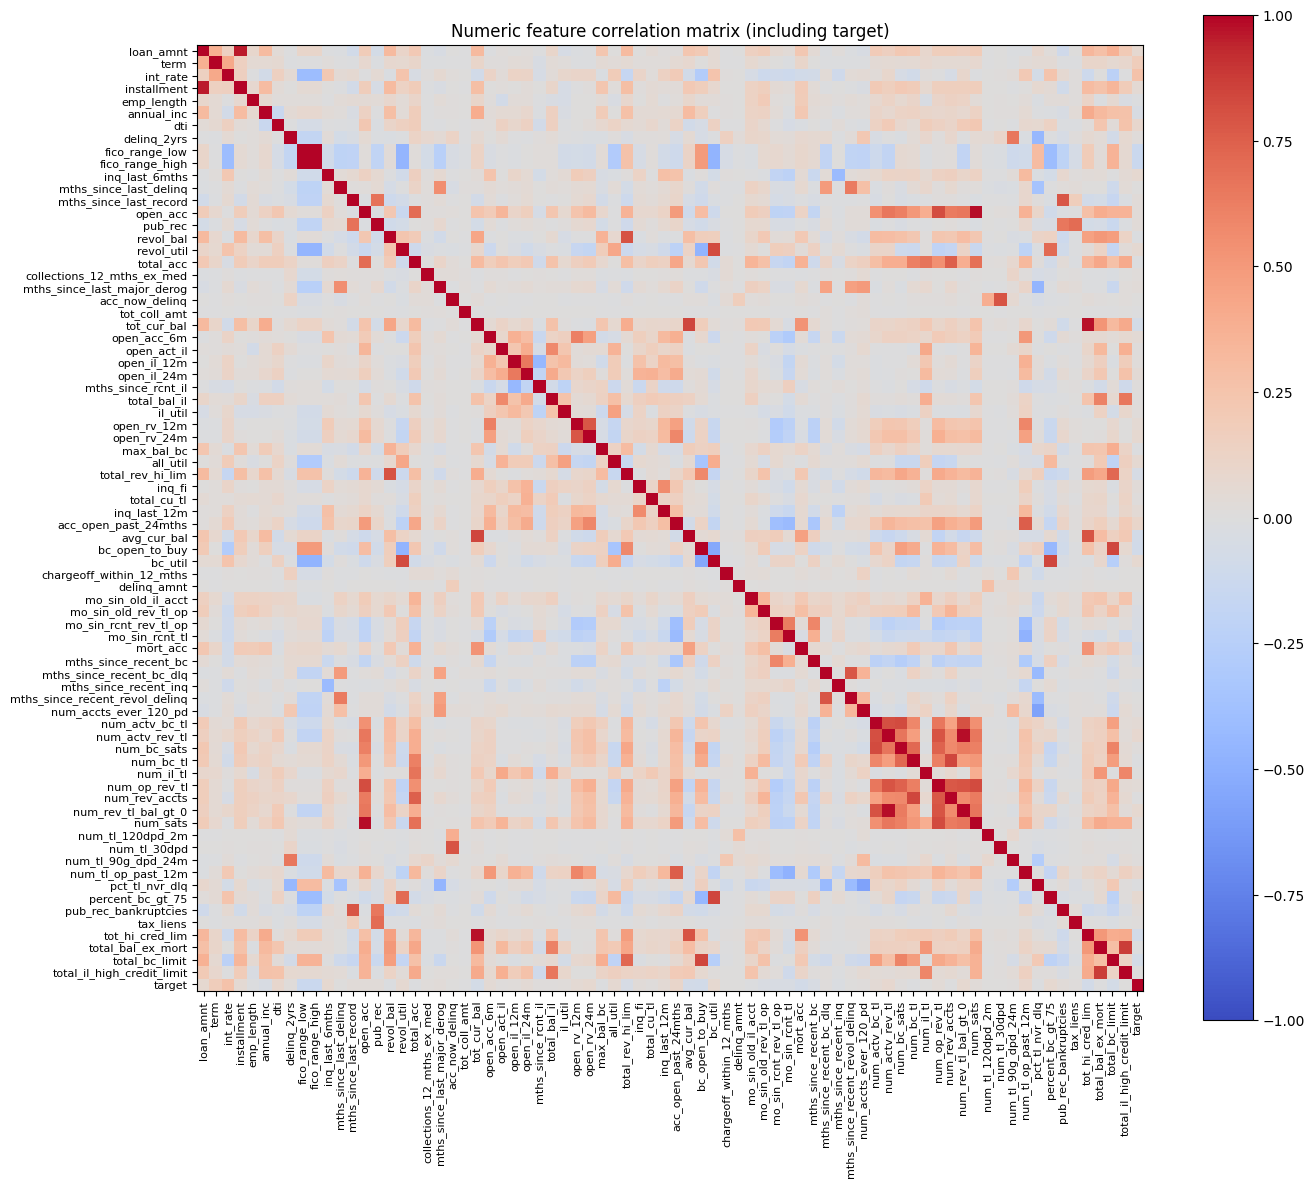

fico_range_low     fico_range_high               1.000000
open_acc           num_sats                      0.983828
num_actv_rev_tl    num_rev_tl_bal_gt_0           0.982058
tot_cur_bal        tot_hi_cred_lim               0.972952
loan_amnt          installment                   0.953401
total_bal_ex_mort  total_il_high_credit_limit    0.869404
bc_util            percent_bc_gt_75              0.843013
num_bc_tl          num_rev_accts                 0.838797
bc_open_to_buy     total_bc_limit                0.838083
tot_cur_bal        avg_cur_bal                   0.836220
revol_util         bc_util                       0.827281
num_op_rev_tl      num_sats                      0.827232
num_actv_bc_tl     num_bc_sats                   0.826957
open_acc           num_op_rev_tl                 0.817893
num_actv_bc_tl     num_actv_rev_tl               0.808042
revol_bal          total_rev_hi_lim              0.801186
num_actv_bc_tl     num_rev_tl_bal_gt_0           0.801013
avg_cur_bal   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def analyze_numeric_correlations(df, *, top_n=20, plot=True, figsize=(14, 12)):
    # numeric-only correlation 
    num_cols = df.select_dtypes(include=[np.number]).columns
    corr = df[num_cols].corr()

    # strongest correlations (absolute, upper triangle only)
    corr_abs = corr.abs()
    upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

    high_corr = (
        upper.stack()
             .sort_values(ascending=False)
    )

    if plot:
        plt.figure(figsize=figsize)
        plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
        plt.colorbar()

        ticks = np.arange(len(corr.columns))
        plt.xticks(ticks, corr.columns, rotation=90, fontsize=8)
        plt.yticks(ticks, corr.columns, fontsize=8)

        plt.title("Numeric feature correlation matrix (including target)")
        plt.tight_layout()
        plt.show()

    return corr, high_corr.head(top_n)



CLEANED_PATH = "/kaggle/input/lending-club-accpted-cleaned/accepted_cleaned.csv"

df_cleaned = pd.read_csv(CLEANED_PATH)

corr_matrix, top_corr = analyze_numeric_correlations(
    df_cleaned,
    top_n=20,
    plot=True
)

top_corr

## Confusion matrix visualization

This function visualizes a confusion matrix using matplotlib. It can display
either raw counts or row-normalized proportions and is used to interpret
classification performance beyond aggregate metrics such as accuracy.

**Parameters**
- `cm`  
  Confusion matrix (array-like, shape `[2, 2]`).

- `class_labels` *(optional)*  
  Labels for negative and positive classes.

- `normalize` *(optional)*  
  If `True`, rows are normalized to show proportions instead of counts.

- `figsize` *(optional)*  
  Size of the matplotlib figure.

- `cmap` *(optional)*  
  Matplotlib colormap used for visualization.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(
    cm,
    *,
    class_labels=("Negative", "Positive"),
    normalize=False,
    figsize=(5, 5),
    cmap="Blues",
):
    cm = np.asarray(cm)

    if normalize:
        cm = cm / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

## CatBoost model training (binary classification)

This function trains and evaluates a CatBoost classifier for a binary
classification task with mixed numeric and categorical features.

The pipeline includes:
- stratified train/test split
- automatic detection of categorical features
- class weighting based on inverse class frequency (computed on training data)
- evaluation using accuracy and confusion matrix

**Parameters**
- `X`  
  Feature DataFrame.

- `y`  
  Binary target vector (`0` / `1`).

- `test_size` *(optional)*  
  Fraction of data reserved for testing.

- `random_state` *(optional)*  
  Random seed for reproducibility.

- `iterations`, `depth`, `learning_rate` *(optional)*  
  Core CatBoost hyperparameters.

- `verbose` *(optional)*  
  Verbosity level passed to CatBoost.

**Returns**
- `model`  
  Trained `CatBoostClassifier`.

- `metrics`  
  Dictionary containing accuracy, confusion matrix, and TN/FP/FN/TP counts.

In [10]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


def train_catboost(
    X,
    y,
    *,
    test_size=0.2,
    random_state=42,
    iterations=1000,
    depth=6,
    learning_rate=0.01,
    verbose=100,
):
    # train / test split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )

    # categorical feature indices (CatBoost requires column indices)
    cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

    # class weights (inverse frequency on TRAIN only)
    n0 = int((y_train == 0).sum())
    n1 = int((y_train == 1).sum())
    w0 = 1.0
    w1 = n0 / n1 if n1 > 0 else 1.0

    print(
        f"Train distribution: n0={n0:,}, n1={n1:,} "
        f"-> class_weights=[{w0:.3f}, {w1:.3f}]"
    )

    model = CatBoostClassifier(
        iterations=iterations,
        depth=depth,
        learning_rate=learning_rate,
        loss_function="Logloss",
        eval_metric="Accuracy",
        class_weights=[w0, w1],
        random_seed=random_state,
        verbose=verbose,
    )

    model.fit(
        X_train,
        y_train,
        cat_features=cat_idx,
        eval_set=(X_test, y_test),
        use_best_model=True,
    )

    # evaluation
    y_pred = model.predict(X_test).astype(int).ravel()

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    print("\nAccuracy:", acc)
    print("\nConfusion Matrix:\n", cm)
    print(f"\nTN={tn:,}  FP={fp:,}  FN={fn:,}  TP={tp:,}")

    metrics = {
        "accuracy": acc,
        "confusion_matrix": cm,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
    }

    return model, metrics

## Logistic Regression training (binary classification)

This function trains and evaluates a Logistic Regression classifier for a binary
classification task with mixed numeric and categorical features.

The function builds a full scikit-learn pipeline that:
- splits the data using a stratified train/test split
- scales numeric features using `StandardScaler`
- encodes categorical features using one-hot encoding (`OneHotEncoder`)
- trains a regularized Logistic Regression model (L1/L2 via `penalty`, strength via `C`)
- handles class imbalance via `class_weight` (default: `"balanced"`)
- prints accuracy and confusion matrix when `verbose=True`

**Parameters**
- `X`  
  Feature DataFrame.

- `y`  
  Binary target vector (`0` / `1`).

- `test_size`, `random_state` *(optional)*  
  Train/test split configuration.

- `penalty`, `C`, `max_iter` *(optional)*  
  Logistic Regression regularization settings.

- `class_weight` *(optional)*  
  Class weighting strategy (default: `"balanced"`).

- `verbose` *(optional)*  
  Controls logging output.

**Returns**
- `pipe`  
  Trained scikit-learn `Pipeline` (preprocessing + model).

- `metrics`  
  Dictionary containing accuracy, confusion matrix, TN/FP/FN/TP, and detected column lists.


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix


def train_logreg(
    X,
    y,
    *,
    test_size=0.2,
    random_state=42,
    penalty="l2",
    C=1.0,
    max_iter=1000,
    class_weight="balanced",
    verbose=True,
):
    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )

    # column types
    cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

    if verbose:
        print(f"Columns: {len(num_cols)} numeric, {len(cat_cols)} categorical (OHE + scaling)")
        n0 = int((y_train == 0).sum())
        n1 = int((y_train == 1).sum())
        print(f"Train distribution: n0={n0:,}, n1={n1:,}")

    # OneHotEncoder sklearn version compatibility:
    # - older: sparse=
    # - newer: sparse_output=
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", ohe, cat_cols),
        ],
        remainder="drop",
    )

    model = LogisticRegression(
        penalty=penalty,
        C=C,
        max_iter=max_iter,
        class_weight=class_weight,
        n_jobs=-1,
    )

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", model),
        ]
    )

    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    if verbose:
        print("\nAccuracy:", acc)
        print("\nConfusion Matrix:\n", cm)
        print(f"\nTN={tn:,}  FP={fp:,}  FN={fn:,}  TP={tp:,}")

    metrics = {
        "accuracy": acc,
        "confusion_matrix": cm,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "num_cols": num_cols,
        "cat_cols": cat_cols,
    }

    return pipe, metrics


## Random Forest training (binary classification)

This function trains and evaluates a Random Forest classifier for a binary
classification task with mixed numeric and categorical features.

Categorical features are one-hot encoded automatically. Numeric features are
used as-is (no scaling required). Class imbalance is handled via class weights.

**Pipeline steps**
- stratified train/test split
- one-hot encoding of categorical features
- Random Forest training
- evaluation via accuracy and confusion matrix

**Parameters**
- `X`  
  Feature DataFrame.

- `y`  
  Binary target vector (`0` / `1`).

- `n_estimators`, `max_depth`, `min_samples_leaf` *(optional)*  
  Core Random Forest hyperparameters.

- `class_weight` *(optional)*  
  Class weighting strategy (default: `"balanced"`).

- `verbose` *(optional)*  
  Controls logging output.

**Returns**
- `pipe`  
  Trained scikit-learn pipeline.

- `metrics`  
  Dictionary containing accuracy, confusion matrix, and TN/FP/FN/TP counts.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


def train_random_forest_binary(
    X,
    y,
    *,
    test_size=0.2,
    random_state=42,
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",
    n_jobs=-1,
    verbose=True,
):
    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )

    # column types
    cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()

    if verbose:
        print(
            f"Columns: {len(num_cols)} numeric, {len(cat_cols)} categorical "
            f"(OHE for categoricals)"
        )
        n0 = int((y_train == 0).sum())
        n1 = int((y_train == 1).sum())
        print(f"Train distribution: n0={n0:,}, n1={n1:,}")

    # OneHotEncoder compatibility across sklearn versions
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)

    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", num_cols),
            ("cat", ohe, cat_cols),
        ],
        remainder="drop",
    )

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight,
        random_state=random_state,
        n_jobs=n_jobs,
    )

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", model),
        ]
    )

    # train
    pipe.fit(X_train, y_train)

    # evaluate
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    if verbose:
        print("\nAccuracy:", acc)
        print("\nConfusion Matrix:\n", cm)
        print(f"\nTN={tn:,}  FP={fp:,}  FN={fn:,}  TP={tp:,}")

    metrics = {
        "accuracy": acc,
        "confusion_matrix": cm,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "num_cols": num_cols,
        "cat_cols": cat_cols,
    }

    return pipe, metrics

## LightGBM training (binary classification)

This function trains and evaluates a LightGBM classifier for a binary
classification task with mixed numeric and categorical features.

Categorical columns (`object` dtype) are converted to pandas `category` dtype so
LightGBM can handle them natively. Class imbalance is handled using
`scale_pos_weight`, computed from the training split only.

**Pipeline steps**
- stratified train/test split
- convert categorical features to `category` dtype
- train LightGBM with early stopping
- evaluate using accuracy and confusion matrix

**Parameters**
- `X`, `y`  
  Features and binary target.

- Core hyperparameters *(optional)*  
  `n_estimators`, `learning_rate`, `num_leaves`, `max_depth`, etc.

- `verbose` *(optional)*  
  Controls logging and early-stopping output.

**Returns**
- `model`  
  Trained `LGBMClassifier`.

- `metrics`  
  Dictionary containing accuracy, confusion matrix, TN/FP/FN/TP, and `scale_pos_weight`.


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, average_precision_score

def train_lightgbm(
    X,
    y,
    *,
    test_size=0.2,
    random_state=42,
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    threshold=0.2,
    early_stopping_rounds=200,
    verbose=True,
):
    import lightgbm as lgb

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # categoricals -> category dtype
    cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
    X_train = X_train.copy()
    X_test = X_test.copy()
    for c in cat_cols:
        X_train[c] = X_train[c].astype("category")
        X_test[c] = X_test[c].astype("category")

    if verbose:
        n0 = int((y_train == 0).sum())
        n1 = int((y_train == 1).sum())
        print(f"Columns: {X_train.select_dtypes(include=['number']).shape[1]} numeric, {len(cat_cols)} categorical")
        print(f"Train distribution: n0={n0:,}, n1={n1:,}  pos_rate={n1/(n0+n1):.3f}")

    model = lgb.LGBMClassifier(
        objective="binary",
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=max_depth,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        is_unbalance=True,        # <<< handles imbalance internally
        random_state=random_state,
        n_jobs=-1,
        force_col_wise=True,
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
        categorical_feature="auto",
        callbacks=[lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=verbose)],
    )

    # probabilities + threshold
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    # metrics
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    ap = average_precision_score(y_test, y_proba)  # PR-AUC

    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    if verbose:
        print(f"\nAUC: {auc:.6f}")
        print(f"PR-AUC (Average Precision): {ap:.6f}")
        print(f"Accuracy (@thr={threshold}): {acc:.6f}")
        print("\nConfusion Matrix:\n", cm)
        print(f"\nTN={tn:,}  FP={fp:,}  FN={fn:,}  TP={tp:,}")
        if getattr(model, "best_iteration_", None):
            print(f"\nBest iteration: {model.best_iteration_}")

    metrics = {
        "accuracy": acc,
        "auc": auc,
        "avg_precision": ap,
        "confusion_matrix": cm,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "threshold": threshold,
        "cat_cols": cat_cols,
    }

    return model, metrics, y_proba

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler


def train_mlp(
    X,
    y,
    *,
    test_size=0.2,
    random_state=42,
    hidden_layer_sizes=(128, 64),
    activation="relu",
    alpha=1e-4,
    learning_rate_init=1e-3,
    max_iter=50,
    early_stopping=True,
    validation_fraction=0.1,
    batch_size=2048,
    verbose=True,
):
    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=y,
    )

    # resample TRAIN only (handle imbalance)
    rus = RandomUnderSampler(random_state=random_state)
    X_train_rs, y_train_rs = rus.fit_resample(X_train, y_train)

    # detect column types
    cat_cols = X_train_rs.select_dtypes(include=["object"]).columns.tolist()
    num_cols = X_train_rs.select_dtypes(include=["number"]).columns.tolist()

    # OneHotEncoder compatibility
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

    preprocess = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", ohe, cat_cols),
        ],
        remainder="drop",
    )

    if verbose:
        print(f"Columns: {len(num_cols)} numeric, {len(cat_cols)} categorical (OHE + scaling)")
        print("After undersampling train distribution:")
        print(y_train_rs.value_counts())

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter=max_iter,
        early_stopping=early_stopping,
        validation_fraction=validation_fraction,
        batch_size=batch_size,
        random_state=random_state,
        verbose=False,
    )

    pipe = Pipeline(
        steps=[
            ("preprocess", preprocess),
            ("model", mlp),
        ]
    )

    pipe.fit(X_train_rs, y_train_rs)

    # evaluate on ORIGINAL test set
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    if verbose:
        print("\nAccuracy:", acc)
        print("\nConfusion Matrix:\n", cm)
        print(f"\nTN={tn:,}  FP={fp:,}  FN={fn:,}  TP={tp:,}")

    metrics = {
        "accuracy": acc,
        "confusion_matrix": cm,
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp,
        "num_cols": num_cols,
        "cat_cols": cat_cols,
    }

    return pipe, metrics

In [1]:
import pandas as pd

# Load cleaned dataset
CLEANED_PATH = "/kaggle/input/lending-club-accpted-cleaned/accepted_cleaned.csv"
df_cleaned = load_csv(CLEANED_PATH, verbose=True)

# Separate features and target
X = df_cleaned.drop(columns=["target"])
y = df_cleaned["target"]

# Train CatBoost
cat_model, cat_metrics = train_catboost(
    X,
    y,
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    verbose=100,
)

# Train Logistic Regression
lr_model, lr_metrics = train_logreg(
    X,
    y,
    penalty="l2",
    C=1.0,
    max_iter=1000,
    class_weight="balanced",
    verbose=True,
)

rf_model, rf_metrics = train_random_forest_binary(
    X,
    y,
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=50,
    verbose=True,
)

lgb_model, lgb_metrics, lgb_proba = train_lightgbm(
    X, y,
    learning_rate=0.03,
    n_estimators=8000,
    num_leaves=31,
    min_child_samples=500,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=5.0,
    early_stopping_rounds=300,
    threshold=0.2,
    verbose=True
)

mlp_model, mlp_metrics = train_mlp(
    X,
    y,
    hidden_layer_sizes=(256, 128, 128, 64),
    max_iter=2000,
    batch_size=2048,
    verbose=True,
)

NameError: name 'load_csv' is not defined

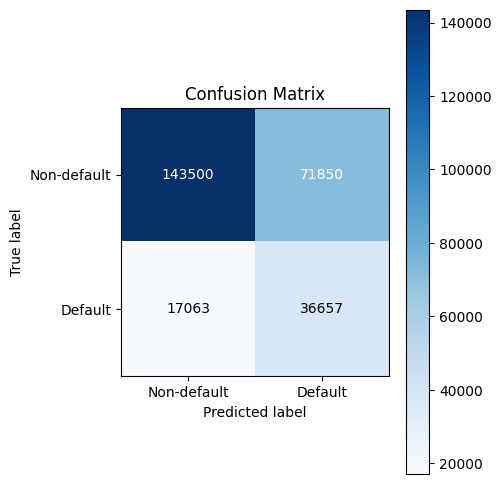

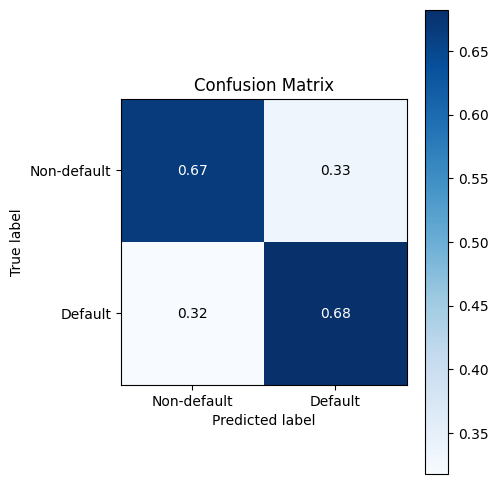

In [6]:
cm = metrics["confusion_matrix"]

plot_confusion_matrix(
    cm,
    class_labels=("Non-default", "Default"),
    normalize=False,
)

# Normalized version
plot_confusion_matrix(
    cm,
    class_labels=("Non-default", "Default"),
    normalize=True,
)

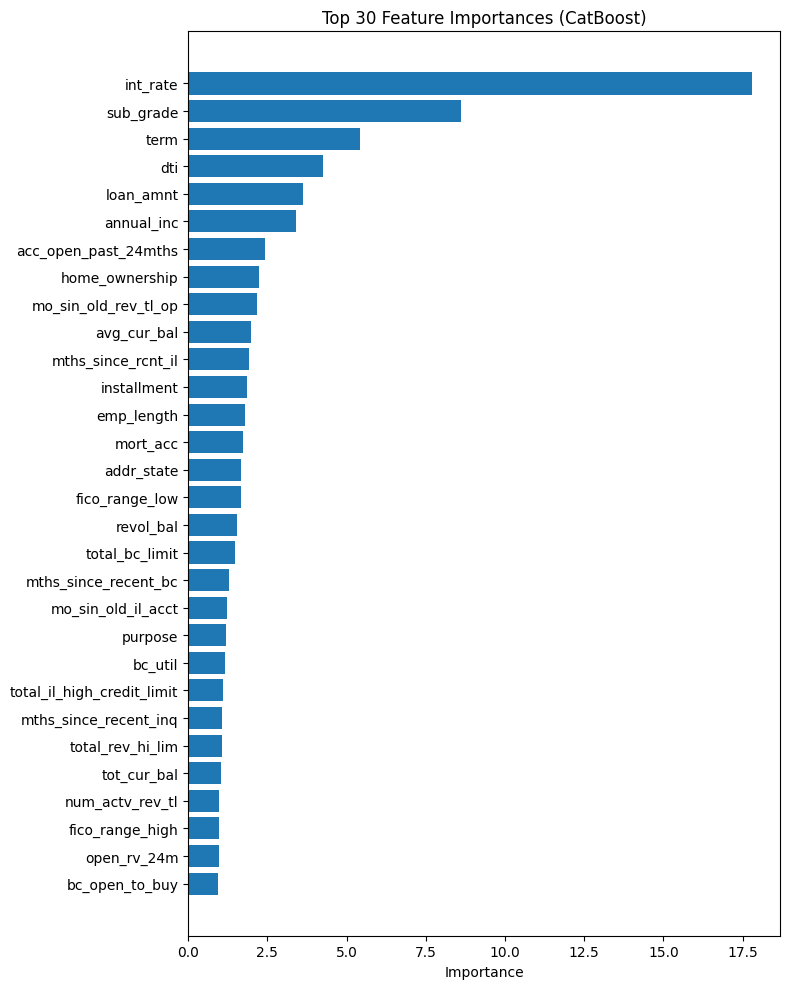

,feature,importance
0,int_rate,17.788388
1,sub_grade,8.612019
2,term,5.424641
3,dti,4.241308
4,loan_amnt,3.629325
5,annual_inc,3.396900
6,acc_open_past_24mths,2.431458
7,home_ownership,2.245075
8,mo_sin_old_rev_tl_op,2.164363
9,avg_cur_bal,1.994925


In [5]:
import pandas as pd
import matplotlib.pyplot as plt


def analyze_feature_importance(
    model,
    feature_names,
    *,
    top_n=30,
    plot=True,
    figsize=(8, 10),
):
    importances = model.get_feature_importance()
    fi = (
        pd.DataFrame(
            {
                "feature": feature_names,
                "importance": importances,
            }
        )
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )

    if plot:
        top = fi.head(top_n)[::-1]

        plt.figure(figsize=figsize)
        plt.barh(top["feature"], top["importance"])
        plt.title(f"Top {top_n} Feature Importances (CatBoost)")
        plt.xlabel("Importance")
        plt.tight_layout()
        plt.show()

    return fi

fi = analyze_feature_importance(
    model,
    feature_names=X.columns,
    top_n=30,
    plot=True,
)

fi.head(20)


In [4]:
CLEANED_PATH = "/kaggle/input/lending-club-accpted-cleaned/accepted_cleaned.csv"

top_features = [
    "int_rate",
    "sub_grade",
    "term",
    "dti",
    "loan_amnt",
    "annual_inc",
    "acc_open_past_24mths",
    "home_ownership",
    "mo_sin_old_rev_tl_op",
    "avg_cur_bal",
    "mths_since_rcnt_il",
    "installment",
    "emp_length",
    "mort_acc",
    "addr_state",
    "fico_range_low",
    "revol_bal",
    "total_bc_limit",
    "mths_since_recent_bc",
    "mo_sin_old_il_acct",
]

usecols = top_features + ["target"]

df_small = load_csv(CLEANED_PATH, usecols=usecols, verbose=True)

print("Loaded reduced dataset shape:", df_small.shape)
print("Missing columns (if any):", [c for c in usecols if c not in df_small.columns])


[load] Reading: /kaggle/input/lending-club-accpted-cleaned/accepted_cleaned.csv
[load] usecols=21 columns
[load] Done. shape=(1345350, 21)  memory≈386.03 MB
Loaded reduced dataset shape: (1345350, 21)
Missing columns (if any): []


In [12]:
X_small = df_small.drop(columns=["target"])
y_small = df_small["target"]

model_small, metrics_small = train_catboost(
    X_small,
    y_small,
    iterations=1000,
    depth=6,
    learning_rate=0.01,
    verbose=100,
)

Train distribution: n0=861,401, n1=214,879 -> class_weights=[1.000, 4.009]
0:	learn: 0.6415751	test: 0.6421510	best: 0.6421510 (0)	total: 686ms	remaining: 11m 25s
100:	learn: 0.6508619	test: 0.6510651	best: 0.6511442 (98)	total: 57s	remaining: 8m 27s
200:	learn: 0.6544340	test: 0.6528654	best: 0.6529003 (198)	total: 1m 54s	remaining: 7m 36s
300:	learn: 0.6577077	test: 0.6563396	best: 0.6564049 (296)	total: 2m 58s	remaining: 6m 53s
400:	learn: 0.6594861	test: 0.6583064	best: 0.6583064 (400)	total: 4m 4s	remaining: 6m 5s
500:	learn: 0.6608621	test: 0.6594861	best: 0.6595839 (494)	total: 5m 11s	remaining: 5m 10s
600:	learn: 0.6616407	test: 0.6604849	best: 0.6605548 (598)	total: 6m 17s	remaining: 4m 10s
700:	learn: 0.6623289	test: 0.6610657	best: 0.6610773 (697)	total: 7m 22s	remaining: 3m 8s
800:	learn: 0.6631217	test: 0.6613973	best: 0.6615256 (776)	total: 8m 27s	remaining: 2m 6s
900:	learn: 0.6637218	test: 0.6621458	best: 0.6621482 (891)	total: 9m 32s	remaining: 1m 2s
999:	learn: 0.6642